In [1]:
import modeller
import fitter

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy
import pandas as pd

In [2]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+H+G+R),
        b*S*I/(S+E+I+H+G+R)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        a*I,
        m*I,
        g*E,
        e*I
    ]

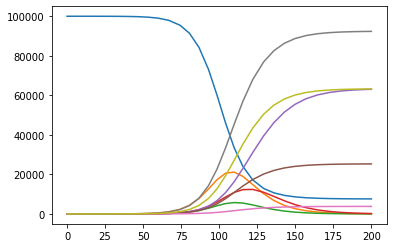

In [3]:
from scipy.integrate import solve_ivp

y0 = [1e5, 1, 0, 0, 0, 0, 0, 0, 0]
p_true = [1, 1/10, 1/4, 1/10, 1/10, 0.015]

sol = solve_ivp(lambda t,y: seir(t,y,p_true), [0, 200], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

In [4]:
import random
def sample(t, y, n=20):
    assert len(t) == len(y)
    return sorted(random.sample(list(zip(t, y)), n))

In [5]:
tfine = np.linspace(0, 150, 151)
yfine_pure = sol.sol(tfine).T
yfine = yfine_pure*(1 + 0.02*np.random.randn(*yfine_pure.shape))

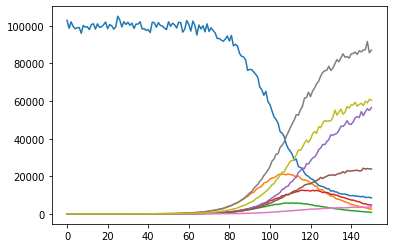

In [6]:
plt.plot(tfine, yfine);

In [7]:
data_time, data = zip(*sample(tfine, yfine))

In [8]:
data_time = np.array(data_time)
data_pd = np.vstack(data).astype(float)

In [9]:
print(data_time)

[  9.  13.  16.  27.  31.  32.  33.  42.  44.  48.  53.  56.  59.  78.
  88. 103. 116. 124. 133. 143.]


In [10]:
extract_data_vector = [3,4,6,7,8]
ex_data_pd = data_pd[:,extract_data_vector]

In [11]:
p0 = [1.5, 1e-6, 0, 1e-6, 1e-6, 0.02]
model_form = {"state": 9, "parameters": 6}
config = {
    "grid_size": 200,
    "basis_number": 32,
    "model_form": model_form,
    "time_span": [0, 200],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": ex_data_pd, "t": data_time},
    "observation_vector": extract_data_vector,
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [12]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 10,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [13]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e1

In [14]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [15]:
prange = np.logspace(-2, 2, num=21)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=0.01

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6894
Number of nonzeros in Lagrangian Hessian.............:     5760

Total number of variables............................:      294
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
T


                                   (scaled)                 (unscaled)
Objective...............:   2.9796853788398744e+02    2.9796853788398744e+02
Dual infeasibility......:   3.3205198754620623e-10    3.3205198754620623e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.1546856303798976e-09    4.1546856303798976e-09
Overall NLP error.......:   4.1546856303798976e-09    4.1546856303798976e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w/o function evaluations)   =      0.197
Total CPU secs in NLP function evaluations           =      0.065

EXIT

  30  1.8722194e+03 0.00e+00 2.11e-03  -5.7 9.91e-01    -  1.00e+00 7.30e-01f  1
In iteration 33, 1 Slack too small, adjusting variable bound

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   1.8722189897705689e+03    1.8722189897705689e+03
Dual infeasibility......:   2.1932075857820277e-10    2.1932075857820277e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.6389118282344340e-09    4.6389118282344340e-09
Overall NLP error.......:   4.6389118282344340e-09    4.6389118282344340e-09


Number of objective function evaluations             = 39
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 39
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian He

In iteration 31, 1 Slack too small, adjusting variable bound
In iteration 32, 1 Slack too small, adjusting variable bound
In iteration 33, 1 Slack too small, adjusting variable bound
In iteration 35, 1 Slack too small, adjusting variable bound

Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:   7.3962103483761157e+03    7.3962103483761157e+03
Dual infeasibility......:   2.2208663686297618e-09    2.2208663686297618e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.2895990792924470e-09    3.2895990792924470e-09
Overall NLP error.......:   3.2895990792924470e-09    3.2895990792924470e-09


Number of objective function evaluations             = 38
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 38
Number of equality constraint Jacobi

Number of inequality constraint evaluations          = 31
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 31
Number of Lagrangian Hessian evaluations             = 30
Total CPU secs in IPOPT (w/o function evaluations)   =      0.152
Total CPU secs in NLP function evaluations           =      0.048

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.68ms ( 86.42us)   2.69ms ( 86.67us)        31
       nlp_g  |   1.22ms ( 39.42us)   1.22ms ( 39.42us)        31
    nlp_grad  | 195.00us (195.00us) 195.34us (195.34us)         1
  nlp_grad_f  |   5.45ms (170.44us)   5.40ms (168.79us)        32
  nlp_hess_l  |  38.26ms (  1.28ms)  38.23ms (  1.27ms)        30
   nlp_jac_g  |   1.70ms ( 53.22us)   1.71ms ( 53.48us)        32
       total  | 205.31ms (205.31ms) 205.12ms (205.12ms)         1
Solving for p=3.981071705534973
This is Ipopt version 3.12.3, running with lin

   0  1.5466944e+05 7.68e-08 3.95e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  10  1.5102837e+05 0.00e+00 4.67e+01  -2.5 2.06e+03    -  9.98e-01 6.08e-01f  1
  20  1.5102175e+05 0.00e+00 2.86e-02  -5.7 1.44e-01    -  9.72e-01 3.88e-01f  1
In iteration 23, 1 Slack too small, adjusting variable bound
  30  1.5102175e+05 0.00e+00 5.08e-08  -9.0 2.50e-10    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 39

                                   (scaled)                 (unscaled)
Objective...............:   1.5102174548909560e+05    1.5102174548909560e+05
Dual infeasibility......:   1.9570470752080938e-08    1.9570470752080938e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.1161858939108084e-10    9.1161858939108084e-10
Overall NLP error.......:   1.9570470752080938e-08    1.9570470752080938e-08


Number of objective function evaluations             = 64
Number of objective gradient evaluations             = 40
Number of 

  20  4.8323449e+05 0.00e+00 8.76e+01  -2.5 4.03e+02  -7.8 1.00e+00 9.41e-01f  1
  30  4.8314967e+05 0.00e+00 2.05e-01  -3.8 1.04e-01    -  8.33e-01 1.00e+00f  1
In iteration 38, 1 Slack too small, adjusting variable bound
  40  4.8314966e+05 0.00e+00 1.63e-05  -8.6 3.58e-04    -  9.89e-01 1.00e+00h  1
In iteration 40, 1 Slack too small, adjusting variable bound
  50  4.8314966e+05 0.00e+00 5.87e-08  -8.6 8.43e-11    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 56

                                   (scaled)                 (unscaled)
Objective...............:   4.8314965935774375e+05    4.8314965935774375e+05
Dual infeasibility......:   1.8124319678544455e-07    1.8124319678544455e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5199549116796993e-09    2.5199549116796993e-09
Overall NLP error.......:   1.8124319678544455e-07    1.8124319678544455e-07


Number of objective function evaluations             = 78
Number 

In [16]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

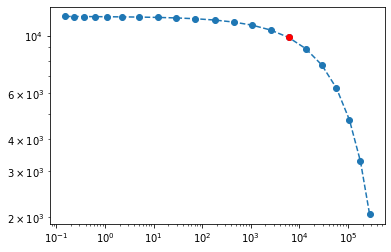

In [20]:
idx = 14
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

(0.0001, 1000.0)

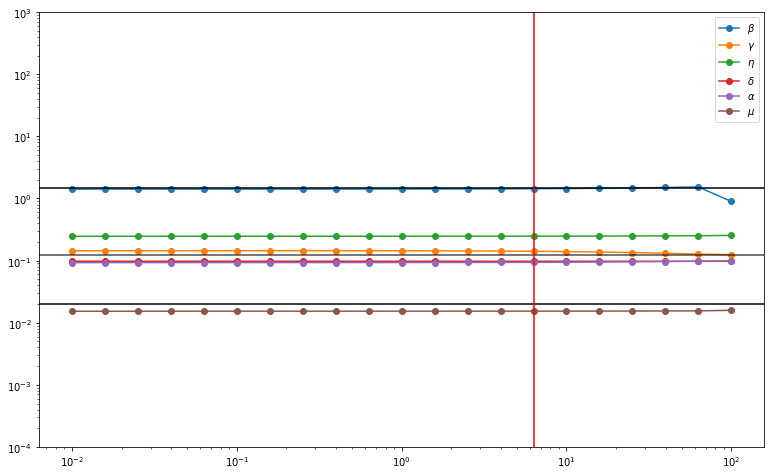

In [21]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-6]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-5]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-4]) for s in sols], 'o-', label=r'$\eta$')
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\delta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\alpha$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\mu$')
for q in p0:
    plt.axhline(q, color='k')
plt.axhline(0.125, color='k', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.ylim([1e-4, 1e3])

(DM(1.43626), DM(0.141449), DM(0.24759), DM(0.0977105), DM(0.0938108), DM(0.0153807))
[1, 0.1, 0.25, 0.1, 0.1, 0.015]


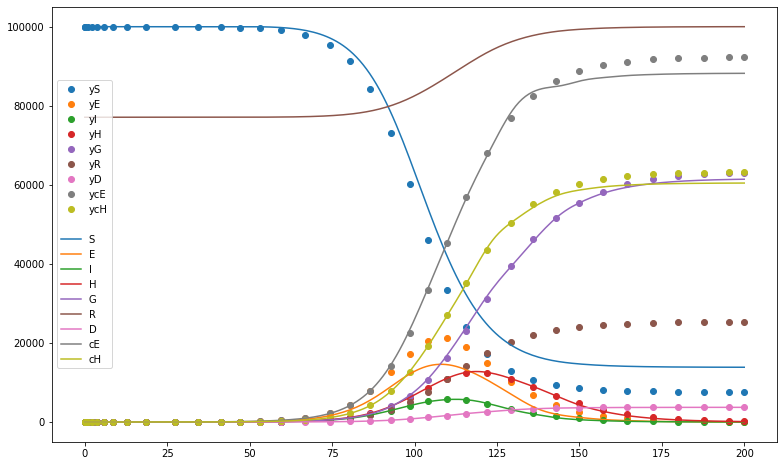

In [22]:
fig, ax=plt.subplots(figsize=[13, 8])
ax.plot(sol.t, sol.y.T, 'o')
ax.plot(0,0, marker="None", linestyle="None")
for data_stripe in getx(sols[idx]['x']):
    ax.plot(model.observation_times, data_stripe)
plt.legend(['yS', 'yE', 'yI', 'yH', 'yG', 'yR', 'yD', 'ycE', 'ycH', '', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
print(getp(sols[idx]['x']))
print(p_true)